## Gibbs Sampling
I'm going to run through an example of a Gibbs sampling. A Gibbs sampler is a usful construction to sample high dimensional distributions. The idea is that if we want to sample a distribution $f(\theta_1,\theta_2,\dots,\theta_n)$, them we can find a condtional distributions for each parameter $\theta_i$, namely, $f(\theta_i \;|\; \theta_{-i})$, where $\theta_{-i}$ is the set of all parameters except $\theta_{i}$. Once we have the conditional distribution, we can choose some initial value and sample the conditional probabilities sequentially based on the previous parameters. It is as if we were randomply sampling the distribution one dimension at a time. 

### Example: Bivariate Normal Distribution
Assume we want to sample a two-dimensional normal distribution.

\begin{align*}
  \left.\begin{bmatrix}\theta_1\\\theta_2\end{bmatrix}\right| y
  \sim \mathcal{N}\left( 
    \begin{bmatrix}y_1\\y_2\end{bmatrix},    
    \begin{bmatrix}1&\rho \\\rho&1\end{bmatrix}
  \right),
  \qquad \text{ where }\begin{bmatrix}1&\rho \\\rho&1\end{bmatrix} \succ 0
\end{align*}

For the covariance matrix, if $\rho = 0$, then the two thetas are independant, meaning that 

\begin{align*}
  \theta_1 \,|\, \theta_2,y &\sim \mathcal{N}(y_1, 1) \\
  \theta_2 \,|\, \theta_1,y &\sim \mathcal{N}(y_2, 1) \\
\end{align*}

In this case we can easily sample each dimension seperately and concatenate the two dimenstions. So for example, if $y_1=5$ and $y_2=2$ we can do the following:

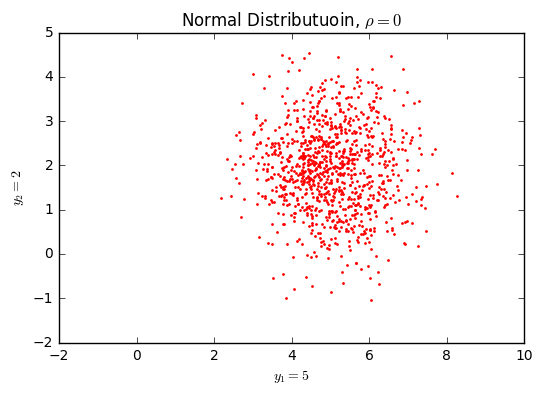

In [63]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

np.random.seed(17700)

# set the means
y1 = 5
y2 = 2

# define the distributions
theta1 = ss.norm(y1,1)
theta2 = ss.norm(y2,1)

# Draw randomly
x1 = theta1.rvs(1000)
x2 = theta2.rvs(1000)

# plot the draws
plt.plot(1)
plt.scatter(x1,x2, s=1, color="r")
plt.title(r"Normal Distributuoin, $\rho=0$")
plt.xlabel(r"$y_1=5$")
plt.ylabel(r"$y_2=2$")
plt.show()

As expected we got a circular blob centered at $(5,2)$ with most the points within 3 units of the center (or 3 standard deviations from the center). We did it by sampling a two distributions independently without the need of MCMC. If we now choose $\rho>0$ it becomes more complicated since the the distributions are no longer independent. 

If we use Gibbs sampling, we can use the conditional distributions, which are

\begin{align*}
  \theta_1 \,|\, \theta_2,y &\sim 
      \mathcal{N}\left(y_1 + \rho(\theta_2-y_2), 1-\rho^2\right) \\
  \theta_2 \,|\, \theta_1,y &\sim 
      \mathcal{N}\left(y_2 + \rho(\theta_1-y_1), 1-\rho^2\right) \\
\end{align*}

Then we can choose an initial value, in this case I'll choose $(0,0)$. From there I'll use that to update $theta_2$ given $\theta_1=0$, next I'll use that new $\theta_2$ value to update $\theta_1$ given $\theta_2$.

In [64]:
theta = np.array([[0.0,0.0]]) # Initial value set to (0,0)
rho = 0.8

# Defining the conditional distributions
drawTheta1 = lambda t_2: ss.norm(y1 + rho*(t_2 - y2), 1 - np.power(rho,2)).rvs()
drawTheta2 = lambda t_1: ss.norm(y2 + rho*(t_1 - y1), 1 - np.power(rho,2)).rvs()

for i in range(1000):
    theta_1 = theta[-1,0] # use previous value for theta_1
    
    # update values using conditional distribution 
    theta_2 = drawTheta2(theta_1) # update theta_2
    theta_1 = drawTheta1(theta_2) # update theta_1

    # store updated values
    draw = np.array([[theta_1, theta_2]]) 
    theta = np.append(theta, draw, axis=0)
    

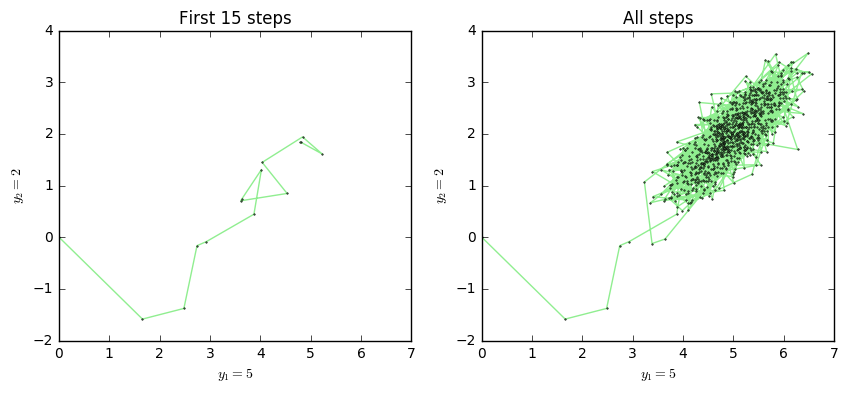

In [65]:
numFirstSteps = 15

# plot the draws
plt.figure(2, figsize=[10,4])
plt.subplot(1,2,1)
plt.xlim(0,7)
plt.ylim(-2,4)
plt.plot(theta[0:numFirstSteps,0], theta[0:numFirstSteps,1], color='lightgreen', linestyle='-', marker='o', ms=1)
plt.title(r"First {} steps".format(numFirstSteps))
plt.xlabel(r"$y_1=5$")
plt.ylabel(r"$y_2=2$")

plt.subplot(1,2,2)
plt.xlim(0,7)
plt.ylim(-2,4)
plt.plot(theta[:,0], theta[:,1], color='lightgreen', linestyle='-', marker='o', ms=1)
plt.title(r"All steps")
plt.xlabel(r"$y_1=5$")
plt.ylabel(r"$y_2=2$")
plt.show()

Since this is a sequential process, I included a line from one point to the next point in the sqeuence, so that we can see the path. All sample points are in black. The plot on the left shows the first 15 steps of the Gibbs sampling process. We can see from the first 15 steps, that it would probably not be a great sampling of the distrbution. If we only need a few samples, we can run, say, 4 times as many steps as we need and only take 1 out of every 4 samples in the sqeuence. 

The plot on the right gives all samples. Notice that the first 5-ish samples are far outside the cloud of other points, and are probably bad samples. This is due to the fact that we started with a bad starting value of $(0,0)$, we needed some time for the sequence to land in a correct region where samples are likely to occur. It is often hard to avoid bad initial values since we might not know where the likely regions are. To avoid these points at the start, it is common to use a "burn-in" which ignores the first few samples. If we used a burn in of 10, we get the following plot

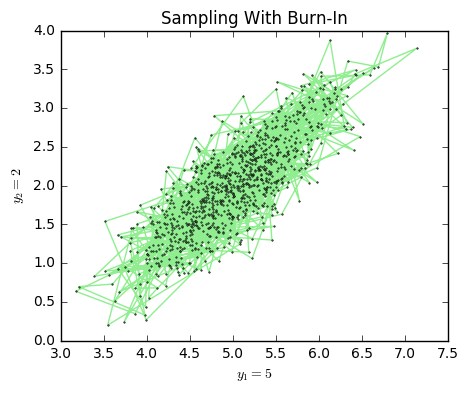

In [66]:
# clear old simulation
theta = np.array([[0.0,0.0]])

burnIn = 10 # set burn-in value

for i in range(1000 + burnIn):
    theta_1 = theta[-1,0] # use previous value for theta_1

    # update values using conditional distribution 
    theta_2 = drawTheta2(theta_1) # update theta_2 given old theta_1
    theta_1 = drawTheta1(theta_2) # update theta_1 given theta_2
    
    # store updated values
    draw = np.array([[theta_1, theta_2]]) 
    theta = np.append(theta, draw, axis=0)

# removing the burn-in values at hte beginning
theta_burnin = theta[burnIn:-1,:]

plt.figure(3, figsize=[5,4])
plt.plot(theta_burnin[:,0], theta_burnin[:,1], color='lightgreen', linestyle='-', marker='o', ms=1)
plt.title(r"Sampling With Burn-In")
plt.xlabel(r"$y_1=5$")
plt.ylabel(r"$y_2=2$")
plt.show()